<a href="https://colab.research.google.com/github/julichitai/learning_NN/blob/CV_Samsung/pytorch_wine_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import torch
from torch import nn
import numpy as np
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

In [72]:
X, y = load_wine(return_X_y=True)
X.shape

(178, 13)

In [87]:
X_train, X_val, y_train, y_val = train_test_split(
    X[:, :2], y,
    random_state=12,
    shuffle=True,
    stratify=y
)

X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)
y_train = torch.LongTensor(y_train)
y_val = torch.LongTensor(y_val)

In [88]:
input_size = X_train.shape[1]
n_hidden = 10
output_size = len(torch.unique(y_train))
batch_size = 10
num_epoch = 1000
learning_rate = 0.001

In [89]:
class WineNet(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, n_hidden)
        self.act1 = nn.Sigmoid()
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, output_size)
        self.sm = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.act1(out)
        out = self.fc2(out)
        out = self.act1(out)
        out = self.fc3(out)
        return out
    
    def inference(self, x):
        out = self.forward(x)
        out = self.sm(out)
        return out


model = WineNet(input_size, n_hidden, output_size)
model

WineNet(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (act1): Sigmoid()
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=3, bias=True)
  (sm): Softmax(dim=1)
)

In [90]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [91]:
for epoch in range(num_epoch):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        X_batch = X_train[start_index:start_index + batch_size]
        y_batch = y_train[start_index:start_index + batch_size]

        output = model(X_batch)
        loss = criterion(output, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 100 == 0:
        train_out = model(X_train)
        train_pred = torch.argmax(train_out, dim=1)
        train_loss = criterion(train_out, y_train)

        val_out = model(X_val)
        val_pred = torch.argmax(val_out, dim=1)
        val_loss = criterion(val_out, y_val)

        print(f'Epoch [{epoch + 1}/{num_epoch}]. Train loss {train_loss.item()}. Val loss {val_loss.item()}')
        print(f'Train acc {(train_pred == y_train).float().mean()}. Val acc {(val_pred == y_val).float().mean()}')

Epoch [100/1000]. Train loss 0.8930123448371887. Val loss 1.0104060173034668
Train acc 0.5413534045219421. Val acc 0.46666666865348816
Epoch [200/1000]. Train loss 0.8622180819511414. Val loss 1.0848298072814941
Train acc 0.5338345766067505. Val acc 0.42222222685813904
Epoch [300/1000]. Train loss 0.8317750692367554. Val loss 1.1056227684020996
Train acc 0.5939849615097046. Val acc 0.6222222447395325
Epoch [400/1000]. Train loss 0.7869298458099365. Val loss 1.101667046546936
Train acc 0.6616541147232056. Val acc 0.5555555820465088
Epoch [500/1000]. Train loss 0.7523378729820251. Val loss 1.1047372817993164
Train acc 0.6691729426383972. Val acc 0.5555555820465088
Epoch [600/1000]. Train loss 0.7259635329246521. Val loss 1.1035428047180176
Train acc 0.6917293071746826. Val acc 0.5555555820465088
Epoch [700/1000]. Train loss 0.6974772214889526. Val loss 1.0876209735870361
Train acc 0.7293233275413513. Val acc 0.644444465637207
Epoch [800/1000]. Train loss 0.6629926562309265. Val loss 1.05

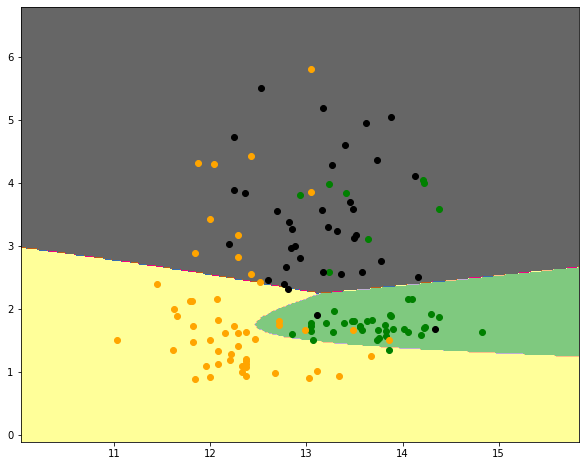

In [92]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['g', 'orange', 'black']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy =  torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                         torch.arange(y_min, y_max, plot_step))

preds = model(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class, cmap='Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(X_train[indexes, 0], 
                X_train[indexes, 1], 
                c=color, 
                cmap='Accent')

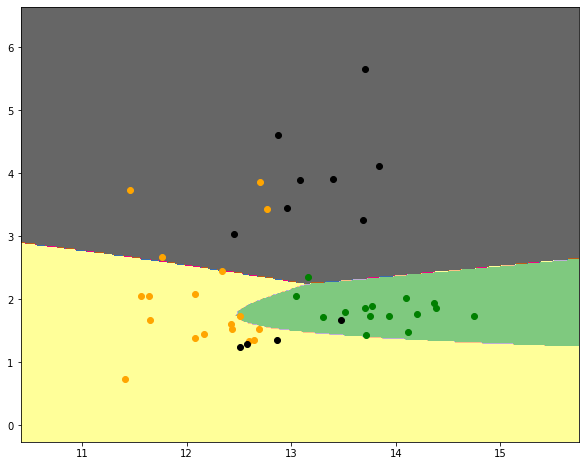

In [93]:
x_min, x_max = X_val[:, 0].min() - 1, X_val[:, 0].max() + 1
y_min, y_max = X_val[:, 1].min() - 1, X_val[:, 1].max() + 1

xx, yy =  torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                         torch.arange(y_min, y_max, plot_step))

preds = model(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class, cmap='Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_val == i)
    plt.scatter(X_val[indexes, 0], 
                X_val[indexes, 1], 
                c=color, 
                cmap='Accent')